# Twilio Conversational Intelligence Notebook

## Overview

Twilio Conversational Intelligence is a powerful service that provides AI-driven insights and analytics for voice and messaging conversations. This service helps businesses understand customer interactions through automated transcription, sentiment analysis, and conversation insights - and also allow for custom analysis based on prompt-based, generative operators.

## What You Can Do With This Notebook

This Jupyter notebook provides a comprehensive toolkit for working with Twilio Conversational Intelligence services:

### Service Management
- Create and configure Conversational Intelligence services
- Manage service settings and parameters
- Update service configurations as needed

### Transcription Generation
- Upload audio files for transcription
- Generate accurate speech-to-text conversions
- Retrieve and manage transcription results

### Operator Testing
- Test different AI operators and configurations
- Analyze conversation insights and sentiment
- Generate sample results for development and testing purposes

## Getting Started

Follow the cells below to authenticate with Twilio, set up your services, and begin processing conversations with AI-powered insights.

In [33]:
%pip install twilio python-dotenv flask pyngrok pandas matplotlib seaborn plotly --quiet


Note: you may need to restart the kernel to use updated packages.


In [1]:
from twilio.rest import Client
import os
import json
import sqlite3
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
from dotenv import load_dotenv
from decimal import Decimal
from flask import Flask, render_template, request, jsonify


# Import all necessary libraries for the notebook
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Load environment variables
load_dotenv()

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

In [2]:

#Initialize Twilio client
account_sid = os.getenv('TWILIO_ACCOUNT_SID')
auth_token = os.getenv('TWILIO_AUTH_TOKEN')
client = Client(account_sid, auth_token)

ngrok_domain = os.getenv('NGROK_DOMAIN')

In [ ]:
# Create Intelligence Service

service_name = input("Enter a unique name for the Intelligence Service: ")
server_url = f'https://{ngrok_domain}/webhook'

service = client.intelligence.v2.services.create(
    unique_name=service_name.lower().replace(' ', '_'),
    friendly_name=service_name,
    auto_transcribe=False,
    data_logging=False,
    language_code='pt-BR',
    auto_redaction=False,
    media_redaction=False,
    webhook_url=server_url,
    webhook_http_method='POST'
)

print(service.sid)

In [24]:
# Create Transcripts Resource

channel_json = {
    "type": "voice",
    "media_properties": {
        "source_sid": "REdd84714d40317d6ad5f9aa1886084400"
    },
    "participants": [{
        "channel_participant": 1,
        "full_name": "Customer",
        "role": "customer",
    }, {
        "channel_participant": 2,
        "full_name": "AI Agent",
        "role": "agent",
    }],
}

transcript = client.intelligence.v2.transcripts.create(
    service_sid=service.sid,
    channel=channel_json,

)

print(f"Transcript SID: {transcript.sid}")


Transcript SID: GT8e3c1486a7848d0e76d1efb1d18c7b90


### Batch Requests

In [3]:
# List Transcripts Incrementally
from datetime import datetime

# Initialize or use existing last_update_date
if 'last_update_date' not in globals():
    # First run - get transcripts from last 24 hours to avoid missing recent ones
    from datetime import timedelta
    last_update_date = datetime.now() - timedelta(days=1)

last_update_time = last_update_date.strftime('%Y-%m-%dT%H:%M:%SZ')
print(f"Fetching transcripts after: {last_update_time}")

transcripts = client.intelligence.v2.transcripts.list(
    limit=100,
    after_date_created=last_update_time,
    after_start_time=last_update_time,
)

print(f"Found {len(transcripts)} new transcripts:\n")

for record in transcripts:
    for key, value in vars(record).items():
        print(f"{key}: {value}")
    print("\n---\n")

# Update the timestamp for next run
last_update_date = datetime.now()
print(f"Updated last_update_date to: {last_update_date}")

Fetching transcripts after: 2025-06-17T09:24:13Z
Found 1 new transcripts:

_version: <Twilio.Intelligence.V2>
account_sid: ACdf269d13302fe4635ab695fb1b477395
service_sid: GAde9c513fd3914897cac25df18f3203b7
sid: GT17c5c6b21b6e45d88549a5b148283baf
date_created: 2025-06-18 01:16:25+00:00
date_updated: 2025-06-18 01:16:36+00:00
status: completed
channel: {'media_properties': {'source': 'ConversationRelay', 'reference_sids': {'call_sid': 'CAfaa1d43461385c3356b60e34f4be82c8'}, 'source_sid': 'VXa4a49109680b7037acdfbd86926f9069', 'media_url': None}, 'participants': [{'user_id': None, 'channel_participant': 1, 'media_participant_id': 'Virtual Agent', 'image_url': None, 'full_name': 'Virtual Agent', 'role': 'Virtual Agent', 'email': None}, {'user_id': None, 'channel_participant': 2, 'media_participant_id': '+551150397615', 'image_url': None, 'full_name': '+551150397615', 'role': 'Customer', 'email': None}], 'type': 'voice'}
data_logging: False
language_code: pt-BR
customer_key: None
media_start_

In [30]:
# List Operator Results for all Transcripts found incrementally
print(f"Getting operator results for {len(transcripts)} transcripts...\n")

for transcript_record in transcripts:
    print(f"TRANSCRIPT: {transcript_record.sid}")
    print("=" * 80)
    
    try:
        operator_results = client.intelligence.v2.transcripts(
            transcript_record.sid
        ).operator_results.list(limit=100)
        
        print(f"Found {len(operator_results)} operator results:\n")
        
        for i, record in enumerate(operator_results, 1):
            print(f"OPERATOR RESULT #{i}")
            print("=" * 60)
            print(f"Name: {record.name}")
            print(f"Type: {record.operator_type}")
            print(f"Operator SID: {record.operator_sid}")
            
            # Handle different result types
            if record.operator_type == 'text-generation' and record.text_generation_results:
                print(f"\nText Generation Result:")
                print("-" * 30)
                result_text = record.text_generation_results.get('result', 'No result available')
                print(f"{result_text}")
                
            elif record.operator_type == 'extract' and record.extract_results:
                print(f"\nExtraction Results:")
                print("-" * 30)
                for entity_type, entities in record.extract_results.items():
                    print(f"  {entity_type}: {entities}")
                
                if record.extract_match:
                    print(f"\nMatch Found: {record.extract_match}")
                    print(f"Match Probability: {record.match_probability}")
                    
                if record.utterance_results:
                    print(f"\nUtterance Analysis:")
                    for j, utterance in enumerate(record.utterance_results):
                        print(f"  Utterance {j+1} (Index {utterance['utterance_index']}):")
                        print(f"    Match Probability: {utterance['match_probability']}")
                        labeled_text = ""
                        for part in utterance['utterance_parts']:
                            if part['label']:
                                labeled_text += f"[{part['label']}: {part['text']}]"
                            else:
                                labeled_text += part['text']
                        print(f"    Text: {labeled_text}")
                
            elif record.operator_type == 'conversation-classify':
                print(f"\nClassification Result:")
                print("-" * 30)
                print(f"Predicted Label: {record.predicted_label}")
                print(f"Predicted Probability: {record.predicted_probability}")
                
                if record.label_probabilities:
                    print(f"All Label Probabilities:")
                    for label, prob in record.label_probabilities.items():
                        print(f"  {label}: {prob}")
            
            print(f"\nTranscript SID: {record.transcript_sid}")
            print(f"URL: {record.url}")
            print("=" * 60)
            print()
            
    except Exception as e:
        print(f"Error fetching operator results for transcript {transcript_record.sid}: {e}")
    
    print("=" * 80)
    print()

Getting operator results for 44 transcripts...

TRANSCRIPT: GT8e3c1486a7848d0e76d1efb1d18c7b90
Found 6 operator results:

OPERATOR RESULT #1
Name: Virtual Agent Performance
Type: text-generation
Operator SID: LY69843e95cea04823b7d80cd08942978a

Text Generation Result:
------------------------------
1) The virtual agent was somewhat consultative but did not ask many follow-up questions to fully understand the customer's needs. After the customer expressed interest in requesting a new card, the agent provided a straightforward answer about how to do so through the app. However, when the customer shifted to inquire about their account balance and a pending PIX transfer, the agent did not probe further into the customer's situation or offer additional assistance related to their account, such as checking the status of the PIX or discussing any potential issues.

2) The virtual agent was effective in handling the customer's initial request about the new card and providing the necessary info

In [4]:
# This script retrieves transcripts and operator results from Twilio's Intelligence API,
# processes them, and saves them into a SQLite database for further analysis.

# Create SQLite database for storing transcripts and operator results
db_path = 'twilio_intelligence.db'
conn = sqlite3.connect(db_path)

# Create tables if they don't exist
conn.execute('''
CREATE TABLE IF NOT EXISTS transcripts (
    sid TEXT PRIMARY KEY,
    service_sid TEXT,
    date_created TEXT,
    date_updated TEXT,
    status TEXT,
    account_sid TEXT,
    channel_data TEXT,
    media_properties TEXT
)
''')

conn.execute('''
CREATE TABLE IF NOT EXISTS operator_results (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    transcript_sid TEXT,
    name TEXT,
    operator_type TEXT,
    operator_sid TEXT,
    predicted_label TEXT,
    predicted_probability REAL,
    extract_match BOOLEAN,
    match_probability REAL,
    text_generation_results TEXT,
    extract_results TEXT,
    label_probabilities TEXT,
    utterance_results TEXT,
    url TEXT,
    FOREIGN KEY (transcript_sid) REFERENCES transcripts (sid)
)
''')

def convert_decimal(value):
    """Convert Decimal objects to float for SQLite compatibility"""
    if isinstance(value, Decimal):
        return float(value)
    return value

# Save transcripts to database
for transcript_record in transcripts:
    conn.execute('''
    INSERT OR REPLACE INTO transcripts 
    (sid, service_sid, date_created, date_updated, status, account_sid, channel_data, media_properties)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?)
    ''', (
        transcript_record.sid,
        transcript_record.service_sid,
        str(transcript_record.date_created),
        str(transcript_record.date_updated),
        transcript_record.status,
        transcript_record.account_sid,
        json.dumps(transcript_record.channel) if hasattr(transcript_record, 'channel') else None,
        json.dumps(transcript_record.media_properties) if hasattr(transcript_record, 'media_properties') else None
    ))

# Save operator results to database
for transcript_record in transcripts:
    try:
        operator_results = client.intelligence.v2.transcripts(
            transcript_record.sid
        ).operator_results.list(limit=100)
        
        for result in operator_results:
            # Convert Decimal values to float
            predicted_probability = convert_decimal(getattr(result, 'predicted_probability', None))
            match_probability = convert_decimal(getattr(result, 'match_probability', None))
            
            conn.execute('''
            INSERT OR REPLACE INTO operator_results 
            (transcript_sid, name, operator_type, operator_sid, predicted_label, predicted_probability,
             extract_match, match_probability, text_generation_results, extract_results, 
             label_probabilities, utterance_results, url)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
            ''', (
                result.transcript_sid,
                result.name,
                result.operator_type,
                result.operator_sid,
                getattr(result, 'predicted_label', None),
                predicted_probability,
                getattr(result, 'extract_match', None),
                match_probability,
                json.dumps(result.text_generation_results) if hasattr(result, 'text_generation_results') and result.text_generation_results else None,
                json.dumps(result.extract_results) if hasattr(result, 'extract_results') and result.extract_results else None,
                json.dumps(result.label_probabilities) if hasattr(result, 'label_probabilities') and result.label_probabilities else None,
                json.dumps(result.utterance_results) if hasattr(result, 'utterance_results') and result.utterance_results else None,
                result.url
            ))
    except Exception as e:
        print(f"Error saving operator results for transcript {transcript_record.sid}: {e}")

conn.commit()

# Create DataFrames for analysis
transcripts_df = pd.read_sql_query("SELECT * FROM transcripts", conn)
operator_results_df = pd.read_sql_query("SELECT * FROM operator_results", conn)

print(f"Saved {len(transcripts_df)} transcripts and {len(operator_results_df)} operator results to database")
print(f"\nTranscripts DataFrame shape: {transcripts_df.shape}")
print(f"Operator Results DataFrame shape: {operator_results_df.shape}")

# Display sample data
print("\nSample Transcripts Data:")
print(transcripts_df.head())

print("\nSample Operator Results Data:")
print(operator_results_df.head())

conn.close()

Saved 45 transcripts and 487 operator results to database

Transcripts DataFrame shape: (45, 8)
Operator Results DataFrame shape: (487, 14)

Sample Transcripts Data:
                                  sid                         service_sid  \
0  GT8e3c1486a7848d0e76d1efb1d18c7b90  GAde9c513fd3914897cac25df18f3203b7   
1  GTc1dd13dc6164d1831df9a340d9fe56ac  GAde9c513fd3914897cac25df18f3203b7   
2  GT2cf35e1363fdd7170d30d45aa174816e  GAde9c513fd3914897cac25df18f3203b7   
3  GTc600a6f6aa7ad12c71e017c36db8b38b  GA50177b2159d5d11cf61fac29b94e4202   
4  GT84fc9a7208613c97f2548beb3b6af6d1  GAeddebfd528173e7d8f9dcf8576775e9e   

                date_created               date_updated     status  \
0  2025-06-15 12:33:23+00:00  2025-06-15 12:33:31+00:00  completed   
1  2025-06-15 12:29:01+00:00  2025-06-15 12:29:11+00:00  completed   
2  2025-06-14 21:55:53+00:00  2025-06-14 21:56:00+00:00  completed   
3  2025-06-14 21:55:50+00:00  2025-06-14 21:55:54+00:00  completed   
4  2025-06-14 21:55:4

Starting Twilio Intelligence Dashboard...
Access the dashboard at: http://localhost:5000
 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/fvieiramachado/Twilio/CX MAS/Voice/.venv/lib/python3.13/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
    ~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/Users/fvieiramachado/Twilio/CX MAS/Voice/.venv/lib/python3.13/site-packages/traitlets/config/application.py", line 1074, in launch_instance
    app.initialize(argv)
    ~~~~~~~~~~~~~~^^^^^^
  File "/Users/fvieiramachado/Twilio/CX MAS/Voice/.venv/lib/python3.13/site-packages/traitlets/config/application.py", line 118, in inner
    return method(app, *args, **kwargs)
  File "/Users/fvieiramachado/Twilio/CX MAS/Voice/.venv/lib/python3.13/site-packages/ipykernel/kernelapp.py", line 692, in initialize
    self.init_sockets()
    ~~~~~~~~~~~~~~~~~^^
  File "/Users/fvieiramachado/

SystemExit: 1

/Users/fvieiramachado/Twilio/CX MAS/Voice/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3680: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Loaded 44 transcripts and 476 operator results


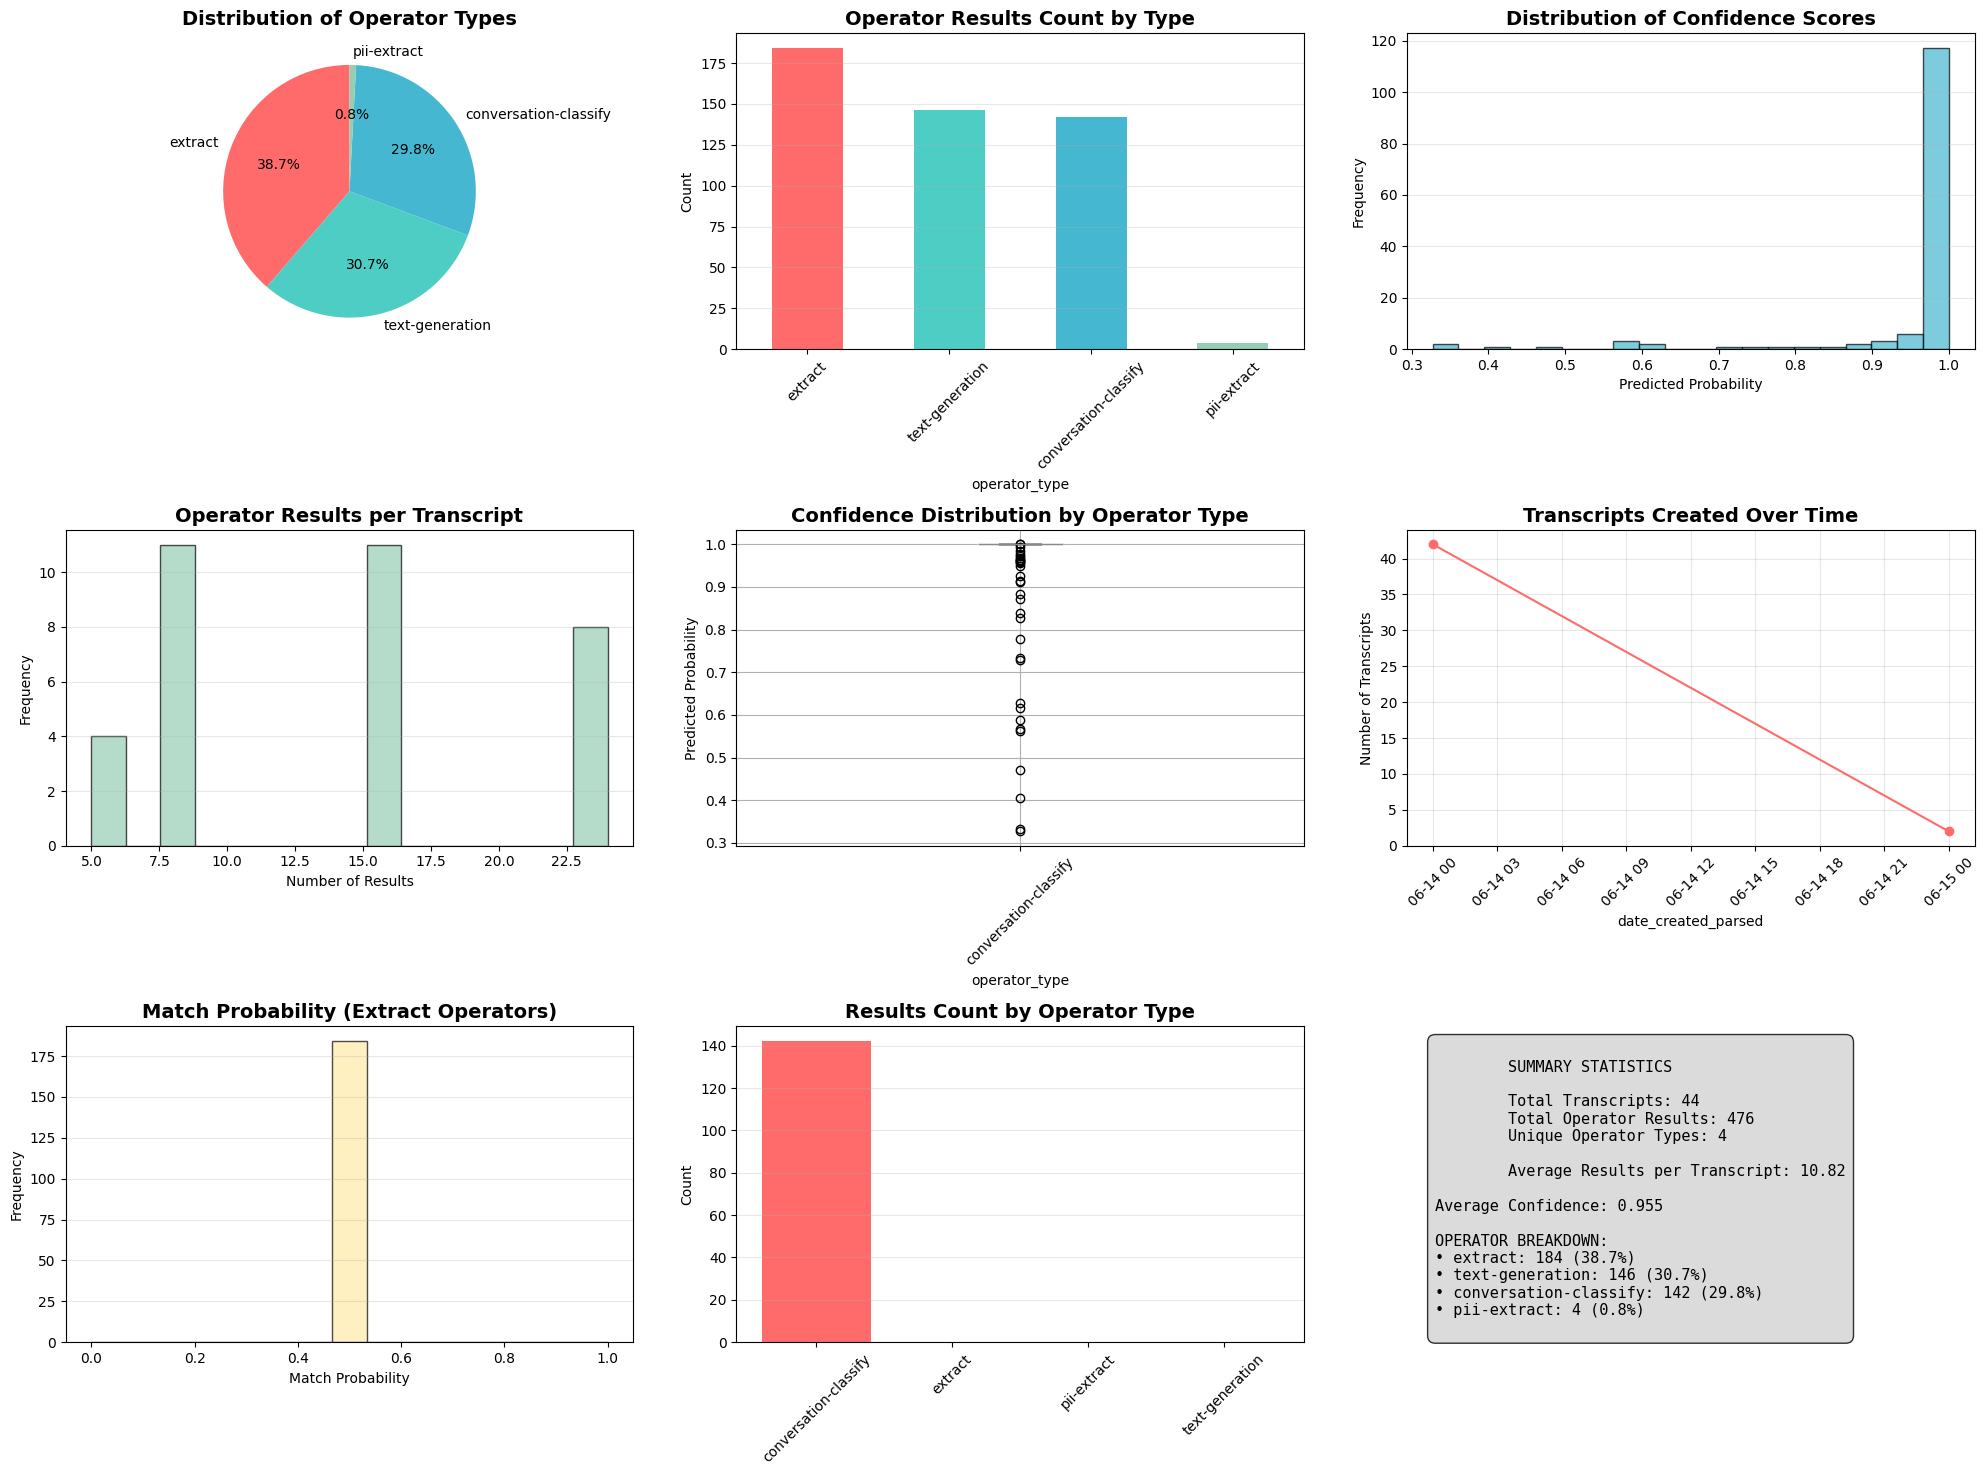


INTERACTIVE VISUALIZATIONS
Error loading data: Mime type rendering requires nbformat>=4.2.0 but it is not installed
Make sure you have run the database population cell first.


In [43]:
# Data Visualization and Analysis Dashboard
# This creates static visualizations instead of a Flask app

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import json
from IPython.display import display, HTML

# Read data from database
db_path = 'twilio_intelligence.db'
conn = sqlite3.connect(db_path)

try:
    # Load data into DataFrames
    transcripts_df = pd.read_sql_query("SELECT * FROM transcripts", conn)
    operator_results_df = pd.read_sql_query("SELECT * FROM operator_results", conn)
    
    print(f"Loaded {len(transcripts_df)} transcripts and {len(operator_results_df)} operator results")
    
    if len(operator_results_df) == 0:
        print("No operator results found. Please run the database population cell first.")
    else:
        # Parse JSON fields for better analysis
        def safe_json_loads(json_str):
            try:
                return json.loads(json_str) if json_str else {}
            except:
                return {}

        operator_results_df['text_gen_parsed'] = operator_results_df['text_generation_results'].apply(safe_json_loads)
        operator_results_df['extract_parsed'] = operator_results_df['extract_results'].apply(safe_json_loads)
        operator_results_df['label_probs_parsed'] = operator_results_df['label_probabilities'].apply(safe_json_loads)

        # Create comprehensive visualizations
        fig = plt.figure(figsize=(20, 15))

        # 1. Operator Type Distribution (Pie Chart)
        plt.subplot(3, 3, 1)
        operator_counts = operator_results_df['operator_type'].value_counts()
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
        plt.pie(operator_counts.values, labels=operator_counts.index, autopct='%1.1f%%', 
                colors=colors[:len(operator_counts)], startangle=90)
        plt.title('Distribution of Operator Types', fontsize=14, fontweight='bold')

        # 2. Operator Type Bar Chart
        plt.subplot(3, 3, 2)
        operator_counts.plot(kind='bar', color=colors[:len(operator_counts)])
        plt.title('Operator Results Count by Type', fontsize=14, fontweight='bold')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)

        # 3. Confidence Score Distribution
        plt.subplot(3, 3, 3)
        confidence_data = operator_results_df[operator_results_df['predicted_probability'].notna()]
        if not confidence_data.empty:
            plt.hist(confidence_data['predicted_probability'], bins=20, alpha=0.7, 
                    color='#45B7D1', edgecolor='black')
            plt.title('Distribution of Confidence Scores', fontsize=14, fontweight='bold')
            plt.xlabel('Predicted Probability')
            plt.ylabel('Frequency')
            plt.grid(axis='y', alpha=0.3)
        else:
            plt.text(0.5, 0.5, 'No confidence data available', ha='center', va='center', 
                    transform=plt.gca().transAxes, fontsize=12)
            plt.title('Confidence Scores (No Data)', fontsize=14, fontweight='bold')

        # 4. Results per Transcript
        plt.subplot(3, 3, 4)
        results_per_transcript = operator_results_df.groupby('transcript_sid').size()
        plt.hist(results_per_transcript, bins=min(15, len(results_per_transcript)), 
                alpha=0.7, color='#96CEB4', edgecolor='black')
        plt.title('Operator Results per Transcript', fontsize=14, fontweight='bold')
        plt.xlabel('Number of Results')
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.3)

        # 5. Confidence by Operator Type (Box Plot)
        plt.subplot(3, 3, 5)
        conf_data = operator_results_df[operator_results_df['predicted_probability'].notna()]
        if not conf_data.empty:
            conf_data.boxplot(column='predicted_probability', by='operator_type', ax=plt.gca())
            plt.title('Confidence Distribution by Operator Type', fontsize=14, fontweight='bold')
            plt.suptitle('')  # Remove automatic title
            plt.ylabel('Predicted Probability')
            plt.xticks(rotation=45)
        else:
            plt.text(0.5, 0.5, 'No confidence data available', ha='center', va='center', 
                    transform=plt.gca().transAxes, fontsize=12)
            plt.title('Confidence by Type (No Data)', fontsize=14, fontweight='bold')

        # 6. Timeline Analysis (if date data is available)
        plt.subplot(3, 3, 6)
        transcripts_df['date_created_parsed'] = pd.to_datetime(transcripts_df['date_created'], errors='coerce')
        if not transcripts_df['date_created_parsed'].isna().all():
            daily_counts = transcripts_df.groupby(transcripts_df['date_created_parsed'].dt.date).size()
            daily_counts.plot(kind='line', marker='o', color='#FF6B6B')
            plt.title('Transcripts Created Over Time', fontsize=14, fontweight='bold')
            plt.ylabel('Number of Transcripts')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)
        else:
            plt.text(0.5, 0.5, 'No date data available', ha='center', va='center', 
                    transform=plt.gca().transAxes, fontsize=12)
            plt.title('Timeline (No Data)', fontsize=14, fontweight='bold')

        # 7. Match Probability Distribution (for extract operators)
        plt.subplot(3, 3, 7)
        match_data = operator_results_df[
            (operator_results_df['operator_type'] == 'extract') & 
            (operator_results_df['match_probability'].notna())
        ]
        if not match_data.empty:
            plt.hist(match_data['match_probability'], bins=15, alpha=0.7, 
                    color='#FFEAA7', edgecolor='black')
            plt.title('Match Probability (Extract Operators)', fontsize=14, fontweight='bold')
            plt.xlabel('Match Probability')
            plt.ylabel('Frequency')
            plt.grid(axis='y', alpha=0.3)
        else:
            plt.text(0.5, 0.5, 'No extract match data', ha='center', va='center', 
                    transform=plt.gca().transAxes, fontsize=12)
            plt.title('Match Probability (No Data)', fontsize=14, fontweight='bold')

        # 8. Operator Success Rate
        plt.subplot(3, 3, 8)
        success_data = operator_results_df.groupby('operator_type').agg({
            'predicted_probability': ['count', 'mean'],
            'match_probability': 'mean'
        }).round(3)
        
        if not success_data.empty:
            op_types = success_data.index
            counts = success_data[('predicted_probability', 'count')]
            plt.bar(range(len(op_types)), counts, color=colors[:len(op_types)])
            plt.title('Results Count by Operator Type', fontsize=14, fontweight='bold')
            plt.ylabel('Count')
            plt.xticks(range(len(op_types)), op_types, rotation=45)
            plt.grid(axis='y', alpha=0.3)

        # 9. Summary Statistics
        plt.subplot(3, 3, 9)
        plt.axis('off')
        
        # Create summary text
        summary_text = f"""
        SUMMARY STATISTICS
        
        Total Transcripts: {len(transcripts_df)}
        Total Operator Results: {len(operator_results_df)}
        Unique Operator Types: {operator_results_df['operator_type'].nunique()}
        
        Average Results per Transcript: {len(operator_results_df) / max(1, len(transcripts_df)):.2f}
        """
        
        if not operator_results_df['predicted_probability'].isna().all():
            avg_conf = operator_results_df['predicted_probability'].mean()
            summary_text += f"\nAverage Confidence: {avg_conf:.3f}"
            
        # Add operator breakdown
        summary_text += "\n\nOPERATOR BREAKDOWN:\n"
        for op_type, count in operator_results_df['operator_type'].value_counts().items():
            percentage = (count / len(operator_results_df)) * 100
            summary_text += f"• {op_type}: {count} ({percentage:.1f}%)\n"
        
        plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes, 
                fontsize=11, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

        plt.tight_layout()
        plt.show()

        # Interactive Plotly visualizations
        print("\n" + "="*60)
        print("INTERACTIVE VISUALIZATIONS")
        print("="*60)

        # Interactive operator distribution
        fig_interactive = px.bar(
            x=operator_counts.index,
            y=operator_counts.values,
            title="Operator Results by Type (Interactive)",
            labels={'x': 'Operator Type', 'y': 'Count'},
            color=operator_counts.index,
            color_discrete_sequence=colors
        )
        fig_interactive.update_layout(showlegend=False)
        fig_interactive.show()

        # Interactive confidence distribution
        if not confidence_data.empty:
            fig_hist = px.histogram(
                confidence_data,
                x='predicted_probability',
                nbins=20,
                title='Confidence Score Distribution (Interactive)',
                labels={'predicted_probability': 'Predicted Probability', 'count': 'Frequency'}
            )
            fig_hist.show()

        # Interactive box plot for confidence by type
        if not conf_data.empty:
            fig_box = px.box(
                conf_data,
                x='operator_type',
                y='predicted_probability',
                title='Confidence Score Distribution by Operator Type',
                color='operator_type'
            )
            fig_box.show()

        print("\n" + "="*60)
        print("DATA ANALYSIS COMPLETE")
        print("="*60)

        # Display webhook server information
        print("\n" + "="*60)
        print("WEBHOOK SERVER INFORMATION")
        print("="*60)
        print(f"Server is running externally via server.py")
        print(f"Webhook URL configured: https://{ngrok_domain}/webhook")
        print(f"You can check server status at: https://{ngrok_domain}/status")
        print(f"Real-time webhook data at: https://{ngrok_domain}/data")
        print("Note: Make sure server.py is running to receive webhooks")

except Exception as e:
    print(f"Error loading data: {e}")
    print("Make sure you have run the database population cell first.")
finally:
    conn.close()

## Individual Requests

In [29]:
# List Operator Results for a specific Transcript
operator_results = client.intelligence.v2.transcripts(
    "GT2cf35e1363fdd7170d30d45aa174816e"
).operator_results.list(limit=100)

for record in operator_results:
    for key, value in vars(record).items():
        print(f"{key}: {value}")
    print("-" * 50)  # Separator between records

_version: <Twilio.Intelligence.V2>
operator_type: text-generation
name: Virtual Agent Performance
operator_sid: LY69843e95cea04823b7d80cd08942978a
extract_match: None
match_probability: None
normalized_result: None
utterance_results: []
utterance_match: None
predicted_label: None
predicted_probability: None
label_probabilities: {}
extract_results: {}
text_generation_results: {'result': "1) The virtual agent was somewhat consultative but did not ask many follow-up questions to fully understand the customer's needs. After the customer expressed interest in requesting a new card, the agent provided a straightforward answer about how to do so through the app. However, when the customer shifted to inquire about their account balance and a pending PIX transfer, the agent responded directly without probing further into the customer's situation or needs. This lack of follow-up questions limited the agent's ability to provide a more tailored service or to explore additional products that might 

In [42]:
# List Operator Results
operator_results = client.intelligence.v2.transcripts(
    "GT2cf35e1363fdd7170d30d45aa174816e"
).operator_results.list(limit=100)

print(f"Found {len(operator_results)} operator results:\n")

for i, record in enumerate(operator_results, 1):
    print(f"OPERATOR RESULT #{i}")
    print("=" * 60)
    print(f"Name: {record.name}")
    print(f"Type: {record.operator_type}")
    print(f"Operator SID: {record.operator_sid}")
    
    # Handle different result types
    if record.operator_type == 'text-generation' and record.text_generation_results:
        print(f"\nText Generation Result:")
        print("-" * 30)
        result_text = record.text_generation_results.get('result', 'No result available')
        print(f"{result_text}")
        
    elif record.operator_type == 'extract' and record.extract_results:
        print(f"\nExtraction Results:")
        print("-" * 30)
        for entity_type, entities in record.extract_results.items():
            print(f"  {entity_type}: {entities}")
        
        if record.extract_match:
            print(f"\nMatch Found: {record.extract_match}")
            print(f"Match Probability: {record.match_probability}")
            
        if record.utterance_results:
            print(f"\nUtterance Analysis:")
            for j, utterance in enumerate(record.utterance_results):
                print(f"  Utterance {j+1} (Index {utterance['utterance_index']}):")
                print(f"    Match Probability: {utterance['match_probability']}")
                labeled_text = ""
                for part in utterance['utterance_parts']:
                    if part['label']:
                        labeled_text += f"[{part['label']}: {part['text']}]"
                    else:
                        labeled_text += part['text']
                print(f"    Text: {labeled_text}")
        
    elif record.operator_type == 'conversation-classify':
        print(f"\nClassification Result:")
        print("-" * 30)
        print(f"Predicted Label: {record.predicted_label}")
        print(f"Predicted Probability: {record.predicted_probability}")
        
        if record.label_probabilities:
            print(f"All Label Probabilities:")
            for label, prob in record.label_probabilities.items():
                print(f"  {label}: {prob}")
    
    print(f"\nTranscript SID: {record.transcript_sid}")
    print(f"URL: {record.url}")
    print("=" * 60)
    print()

Found 6 operator results:

OPERATOR RESULT #1
Name: Virtual Agent Performance
Type: text-generation
Operator SID: LY69843e95cea04823b7d80cd08942978a

Text Generation Result:
------------------------------
1) The virtual agent was somewhat consultative but did not ask many follow-up questions to fully understand the customer's needs. After the customer expressed interest in requesting a new card, the agent provided a straightforward answer about how to do so through the app. However, when the customer shifted to inquire about their account balance and a pending PIX transfer, the agent responded directly without probing further into the customer's situation or needs. This lack of follow-up questions limited the agent's ability to provide a more tailored service or to explore additional products that might benefit the customer.

2) The virtual agent was sufficient for the tasks at hand, as it was able to provide the necessary information regarding the card request and the account balance.

In [ ]:
https://owlbank.ngrok.io/webhook 